###A - IMPORTANT !!!!

Always use "***order = 'F'*** " for np.reshape.

###B - Some matplotlib & MATLAB Commands

If you want to use matplotlib as in the desktop environment, we should add 'nbagg' flag Before importing matplotlib:
matplotlib.use('nbagg')

In [0]:
import matplotlib

print(matplotlib.__version__)
print(matplotlib.get_backend())

2.1.2
module://ipykernel.pylab.backend_inline


In [0]:
matplotlib.use('nbagg')
print(matplotlib.get_backend())

import matplotlib.pyplot as plt

To save a variable in csv file format in MATLAB use:

```
csvwrite(filename,M)
csvwrite(filename,M,row,col)
```


##Pre-Run for DMD Book

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

# For DMD function
from scipy.linalg import svd
from scipy.linalg import eigh
from scipy import linalg
import scipy.io as io

##### Mount GOOGLE DRIVE #####
from google.colab import drive
drive.mount('/content/gdrive')

##### Load .mat file into a variable #####
#cylinder = io.loadmat("CYLINDER_ALL.mat")
#data = cylinder['VORTALL']

##### save the the variable "data" into a .csv file into GOOGLE DRIVE #####
#np.savetxt(("/content/gdrive/My Drive/file.csv"), data, delimiter=',')

##### Load cylinder Data from GOOGLE DRIVE #####
data_cylinder = np.loadtxt(open("/content/gdrive/My Drive/file.csv", "rb"), delimiter=",")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


##myPOD Function

In [0]:
def myPOD(data_cylinder, modes = 4, nx = 199, ny = 449):

  X = data_cylinder #\\\\\\ Checked OK

  m , n = X.shape
  print('m =', m, 'n =', n)

  Y = np.concatenate((X, X), axis=1)  #\\\\\\\ checked OK

  # augment matrix with mirror images to enforce symmetry/anti-symmetry
  for k in range(0, n):
      xflip = np.reshape(np.flipud(np.reshape(X[:,k], (nx, ny), order='F')), (nx * ny, 1), order='F')
      Y[:,n+k] = -xflip[:,0]

  print("Y shape=", Y.shape)

  # compute mean and subtract
  VORTavg = np.mean(Y, axis = 1) # is a row vector containing the mean of each row
  VORTavg = np.asmatrix(VORTavg)
  print("VORTavg shape= ", VORTavg.shape)
  VORTavg = VORTavg.T  #\\\\\\\ checked OK
  print("VORTavg.T shape= ", VORTavg.shape)

  plotCylinder(np.reshape(VORTavg,(nx,ny), order='F'), nx, ny)  # plot average wake
  plt.title('Vortex Average "VORTavg"')
  plt.xlabel('x Domain')
  plt.ylabel('y Domain')

  # compute POD after subtracting mean (i.e., do PCA)
  Yhat = Y - VORTavg * np.ones((1, Y.shape[1]))
  PSI, S, V = np.linalg.svd(Yhat, full_matrices=False)
  # PSI are POD modes
  V = V.T

  fig = plt.figure()
  plt.semilogy(S/sum(S)) # plot singular vals
  plt.title('Singular Values (from SVD)')
  plt.xlabel('Index')
  plt.ylabel('log ( S / sum(S) )')

  S = np.diag(S)
  print("S shape=", S.shape, "S rank =", np.linalg.matrix_rank(S))
  print("PSI shape =", PSI.shape)
  print("V shape =", V.shape)

  for k in range(modes):
    PSIr = np.reshape(PSI[:, k], (nx,ny), order='F')
    fig_title = f'This is POD mode for k = {k}'
    plotCylinder(PSIr, nx, ny, fig_title)
  
  return PSI, S, V, VORTavg, Y

##myDMD Function

In [0]:
def myDMD(data, rank, plot = False):
  m, n = data.shape
  print("m (mesh grids)= nx * ny =", m, "n = time steps =", n)

  xi = np.asmatrix(range(m)).T
  t = np.asmatrix(range(n)).T
  print("t shape :", t.shape, "xi shape :", xi.shape)
  dt = t[2] - t[1]
  
  # Create DMD data matrices
  X1 = data[:, range( 0 , n-1 )]
  X2 = data[:, range( 1 , n )]

  # SVD and rank truncation
  r = rank # rank truncation
  U, s, Vh = svd(X1, full_matrices = False)
  Vh = Vh.conj().T

  Ur = U[:, range(r)]
  Sr = s[range(r)]
  Vr = Vh[: , range(r)]

  Sr = np.diag(Sr)
  Sr = np.asmatrix(Sr)

  # Build Atilde and DMD Modes
  Atilde = np.dot(Ur.T, np.dot(X2, np.dot(Vr, Sr.I)))
  
  D, W = linalg.eig(Atilde, overwrite_a=True)
  W = np.asmatrix(W)
  D = np.diag(D)
  D = np.asmatrix(D)

  # Phi = X2 * Vr / Sr * W   DMD Modes
  Phi = np.dot(X2, np.dot(Vr, np.dot(Sr.I, W)))
  print("Phi shape: ", Phi.shape)

  # DMD Spectra
  lambdaa = np.diag(D)
  lambdaa = np.vstack(lambdaa)
  print("lambdaa shape : ", lambdaa.shape)

  omega = np.log(lambdaa)/dt
  print("omega shape :", omega.shape)

  # Compute DMD Solution
  x1 = data[:, 0]
  x1 = np.asmatrix(x1).conj().T

  b = linalg.lstsq(Phi , x1)[0]
  print("b shape: ", b.shape)

  time_dynamics = np.zeros((r,n), dtype=np.complex)
  print("time_dynamics shape: ", time_dynamics.shape)
  
  for mode in range(r):
    for iter in range(0, n):
        time_dynamics[mode,iter] = b[mode, 0] * np.exp(omega[mode, 0] * t[iter])

  X_dmd = Phi*time_dynamics
  print('X_dmd.shape :', X_dmd.shape)

  ######  Plotting Results  ######
  if plot:
    #Plot DMD Dynamics
    for mode in range(r):
      plt.plot(t, np.real(time_dynamics[mode, :]))
      plt.title('Dynamics', fontsize=14)
      plt.xlabel('time linspace')
      plt.ylabel('time_dynamics b*e(omega*t))')
     
    #Plot DMD Modes
    fig = plt.figure()
    for mode in range(r):
      plotCylinder(np.reshape(Phi[:,mode].real, (nx,ny), order='F'), nx, ny)
      if r > 1:
        plotCylinder(np.reshape(Phi[:,mode].imag, (nx,ny), order='F'), nx, ny)
      plt.title('DMD Modes (Phi)', fontsize=14)
      plt.xlabel('x grid')
      plt.ylabel('y grid')
      
    #Plot DMD spectrum
    plt.figure()
    theta = np.arange(0, 100, 1)*2*np.pi/100
    plt.plot(np.cos(theta),np.sin(theta),'k--') # plot unit circle
    plt.scatter(np.diag(D).real, np.diag(D).imag)
    plt.axis([-1.1, 1.1, -1.1, 1.1])
    
  ######  End of Plotting Results  ###### 

  return D, Atilde, Phi, time_dynamics

##plotCylinder Function

In [0]:
def plotCylinder(VORT, nx, ny, fig_title = ''):
  vortmin = -5  # only plot what is in -5 to 5 range
  vortmax = 5
  
  #CC = np.loadtxt(open("/content/gdrive/My Drive/colormap.csv", "rb"), delimiter=",")
  
  #print('in function nx length =', len(nxx))
  #print('in function ny length =', len(nyy))
  
  VORT[VORT>vortmax] = vortmax  # cutoff at vortmax
  VORT[VORT<vortmin] = vortmin  # cutoff at vortmin
  
  #VORT = np.asmatrix(VORT)
  #print('in function VORT shape =', VORT.shape)
  fig = plt.figure()
  plt.imshow(VORT, cmap='hsv')
  plt.xticks([1, 50, 100, 150, 200, 250, 300, 350, 400, 449], ('-1','0','1','2','3','4','5','6','7','8'))
  plt.yticks([1, 50, 100, 150, 199], ('2','1','0','-1','-2'))
  plt.axis('equal')
  plt.title(fig_title)
  
  plt.contour(VORT, [-5.5  , -4.875, -4.25, -3.625, -3., -2.375, -1.75, -1.125, -0.5, -0.25, -0.125], linestyle = '--', colors='k', linewidths = 1.2)
  plt.contour(VORT, [0.125, 0.25, 0.5, 1.125, 1.75,  2.375, 3., 3.625, 4.25, 4.875, 5.5 ], linestyle = '-', colors='k', linewidths = 1.2)
  
  theta = np.linspace(1,100,100)
  theta = theta/100*2*np.pi
  theta = theta.T

  xtt = 49 + 25*np.sin(theta)
  ytt = 99 + 25*np.cos(theta)
  plt.fill(xtt,ytt,[.3, .3, .3])  # place cylinder
  plt.plot(xtt,ytt,'k') # cylinder boundary

#1 - CHAPTER 1 of DMD Book

In [0]:
# Define time and space discretizations
xi = np.linspace(-10,10,400)
t = np.linspace(0,4*np.pi,200)
dt = t[2] - t[1]
Xgrid, Time = np.meshgrid(xi,t)

In [0]:
# Create two spatio-temporal patterns
f1 = 1/(np.cosh(Xgrid+3)) * (1*np.exp(1j*2.3*Time))
f2 = (1/(np.cosh(Xgrid)) * np.tanh(Xgrid)) * (2*np.exp(1j*2.8*Time))

In [0]:
# Combine signals and make data matrix
f = f1 + f2
data = f.T  # Data Matrix

In [0]:
# Visualize f1, f2, and f
plt.figure(figsize=(12,12))
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(Xgrid, Time, np.real(f1), cmap=cm.coolwarm, linewidth=0, antialiased=False)

plt.figure(figsize=(12,12))
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(Xgrid, Time, np.real(f2), cmap=cm.coolwarm, linewidth=0, antialiased=False)

plt.figure(figsize=(12,12))
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(Xgrid, Time, np.real(f), cmap=cm.coolwarm, linewidth=0, antialiased=False)

#2 - CHAPTER 2 of DMD Book

In [0]:
######## Compute DMD using myDMD ########
D, Atilde, Phi, time_dynamics = myDMD(data_cylinder, 1, True)

m = 89351 n = 151
Y shape= (89351, 302)
VORTavg shape=  (1, 89351)
VORTavg.T shape=  (89351, 1)


/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'linestyle'
  s)


S shape= (302, 302) S rank = 302
PSI shape = (89351, 302)
V shape = (302, 302)


/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


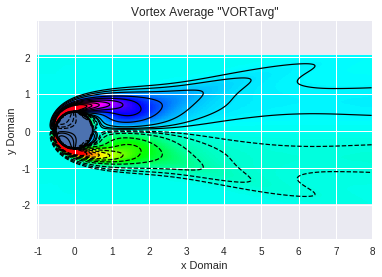

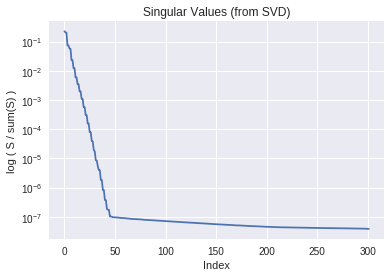

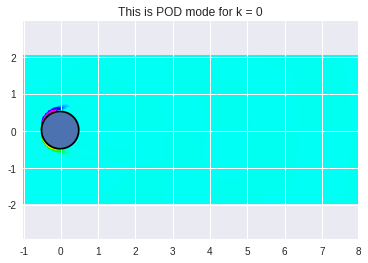

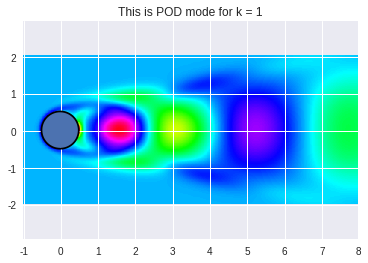

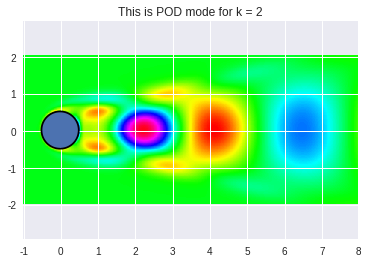

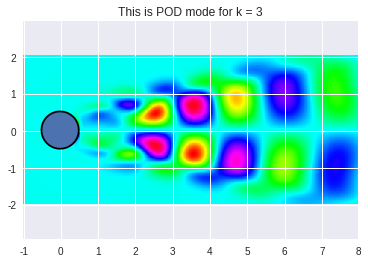

In [0]:
######## Compute POD using myPOD ########
PSI, S, V, VORTavg, Y = myPOD(data_cylinder, 4)

In [0]:
c = Y.T @ Y
w, v = np.linalg.eig(c)

In [0]:
print("V from svd=", V[0,0])
print("V from X.T*X=", v[0,0])
print(V.shape, v.shape)

V from svd= 0.05753241860029092
V from X.T*X= (-0.05774183501596691+0j)
(302, 302) (302, 302)


#Python Packages For Comparing Results

###pydmd

/usr/local/lib/python3.6/dist-packages/pydmd/dmdbase.py:341: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a = np.linalg.lstsq(modes, snapshots.T[0])[0]


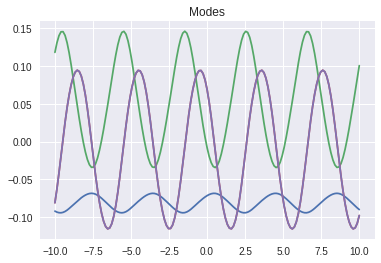

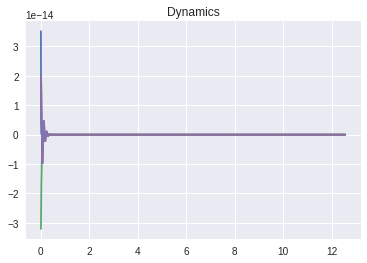

In [0]:
######## Python pydmd Package for Comparison ########

#!pip install pydmd
from pydmd import DMD

xi = np.linspace(-10,10, 151)
t = np.linspace(0,4*np.pi, 89351)
  
dmd = DMD(svd_rank=4)
dmd.fit(data_cylinder.T)

for mode in dmd.modes.T:
    plt.plot(xi, mode.real)
    plt.title('Modes')
plt.show()

for dynamic in dmd.dynamics:
    plt.plot(t, dynamic.real)
    plt.title('Dynamics')
plt.show()  

###sklearn PCA

In [0]:
######## sklearn PCA Package for Comparison ########

nx = 199  # number of grid points of actual mesh in x-direction
ny = 449  # number of grid points of actual mesh in y-direction

from sklearn.decomposition import PCA
pca = PCA(n_components=151)
principalComponents = pca.fit_transform(data_cylinder)
print("principal Components shape =", principalComponents.shape)
print("principal Component =", principalComponents[0,0])
#Plot using below code

principal Components shape = (89351, 151)
principal Component = 0.0006418415365859898


In [0]:
#Plots from above code
for k in range(4):
  PSIr = np.reshape(principalComponents[:, k], (nx,ny), order='F')
  fig_title = f'This is POD mode for k = {k}'
  plotCylinder(PSIr, nx, ny, fig_title)

### DMDpack

In [0]:
######## DMDpack from the below big code ########
m, n = (data_cylinder).shape

xi = np.asmatrix(range(m)).T
t = np.asmatrix(range(n)).T

Fmodes, b, V, omega = dmdpack(data_cylinder, k=4, modes='standard', svd='truncated', return_amplitudes=True, return_vandermonde=True)
Atilde = Fmodes.dot( np.dot(np.diag(b), V))
print("Fmodes shape =", Fmodes.shape)
print("Fmodes =", Fmodes[0,0])

#Plot Modes
#plt.imshow(np.reshape(Fmodes[:, 0], (199, 449), order='F'))
#plt.title('Modes')

Fmodes shape = (89351, 4)
Fmodes = (-2.9469933634599036e-17+0j)


####DMDpack Function

In [0]:
"""Dynamic Mode Decomposition (DMD) python function.
https://github.com/erichson/DMDpack/blob/master/dmd/dmd.py"""

from __future__ import division
import numpy as np
import scipy as sci
from scipy import linalg
import scipy.sparse.linalg as scislin

 
# from rsvd import rsvd

#matrix transpose for real matricies
def rT(A): 
    return A.T
    
#matrix transpose for complex matricies
def cT(A): 
    return A.conj().T      


def dmdpack(A, dt = 1, k=None, p=5, q=2, modes='exact',
        return_amplitudes=False, return_vandermonde=False, 
        svd='truncated', sdist='uniform', order=True):
    """
    Dynamic Mode Decomposition.

    Dynamic Mode Decomposition (DMD) is a data processing algorithm which
    allows to decompose a matrix `A` in space and time. The matrix `A` is 
    decomposed as `A = F * B * V`, where the columns of `F` contain the dynamic modes.
    The modes are ordered corresponding to the amplitudes stored in the diagonal 
    matrix `B`. `V` is a Vandermonde matrix describing the temporal evolution.


    Parameters
    ----------
    A : array_like
        Real/complex input matrix  `a` with dimensions `(m, n)`.
    
    dt : scalar or array_like  
        Factor specifying the time difference between the observations.      
    
    k : int, optional
        If `k < (n-1)` low-rank Dynamic Mode Decomposition is computed.
    
    p : int, optional
        `p` sets the oversampling parameter for rSVD (default `p=5`).
    
    q : int, optional
        `q` sets the number of power iterations for rSVD (default `q=1`).
    
    modes : str `{'standard', 'exact', 'exact_scaled'}`
        'standard' : uses the standard definition to compute the dynamic modes, `F = U * W`.
        
        'exact' : computes the exact dynamic modes, `F = Y * V * (S**-1) * W`.    
        
        'exact_scaled' : computes the exact dynamic modes, `F = (1/l) * Y * V * (S**-1) * W`.
    
    return_amplitudes : bool `{True, False}` 
        True: return amplitudes in addition to dynamic modes. 
    
    return_vandermonde : bool `{True, False}`
        True: return Vandermonde matrix in addition to dynamic modes and amplitudes.
    
    svd : str `{'rsvd', 'partial', 'truncated'}`
        'rsvd' : uses randomized singular value decomposition (default). 
        
        'partial' : uses partial singular value decomposition.
        
        'truncated' : uses truncated singular value decomposition.
    
    sdist : str `{'uniform', 'normal'}`
        'uniform' : Uniform `[-1,1]`.
    
        'normal' : Normal `~N(0,1)`.
            
    order :  bool `{True, False}`
        True: return modes sorted.


    Returns
    -------
    F : array_like
        Matrix containing the dynamic modes of shape `(m, n-1)`  or `(m, k)`.
    
    b : array_like, if `return_amplitudes=True`
        1-D array containing the amplitudes of length `min(n-1, k)`.
    
    V : array_like, if `return_vandermonde=True`
        Vandermonde matrix of shape `(n-1, n-1)`  or `(k, n-1)`.

    omega : array_like
        Time scaled eigenvalues: `ln(l)/dt`. 



    Notes
    -----


    References
    ----------
    J. H. Tu, et al.
    "On Dynamic Mode Decomposition: Theory and Applications" (2013).
    (available at `arXiv <http://arxiv.org/abs/1312.0041>`_).   
    
    N. B. Erichson and C. Donovan.
    "Randomized Low-Rank Dynamic Mode Decomposition for Motion Detection" (2015).
    Under Review.    
    
    
    Examples
    --------
    >>> #Numpy
    >>> import numpy as np
    >>> #DMD
    >>> from skrla import dmd
    >>> #Plot libs
    >>> import matplotlib.pyplot as plt
    >>> from mpl_toolkits.mplot3d import Axes3D
    >>> from matplotlib import cm
    
    >>> #
    >>> # Create an artifical data-set:
    >>> #
    >>> # Define time and space discretizations
    >>> x=np.linspace( -15, 15, 200)
    >>> t=np.linspace(0, 8*np.pi , 80) 
    >>> dt=t[2]-t[1]
    >>> X, T = np.meshgrid(x,t)
    >>> # Create two patio-temporal patterns
    >>> F1 = 0.5* np.cos(X)*(1.+0.* T)
    >>> F2 = ( (1./np.cosh(X)) * np.tanh(X)) *(2.*np.exp(1j*2.8*T))
    >>> # Add both signals
    >>> F = (F1+F2)
    
    >>> #Plot dataset
    >>> fig = plt.figure()
    >>> ax = fig.add_subplot(231, projection='3d')
    >>> ax = fig.gca(projection='3d')
    >>> surf = ax.plot_surface(X, T, F, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=True)
    >>> ax.set_zlim(-1, 1)
    >>> plt.title('F')
    >>> ax = fig.add_subplot(232, projection='3d')
    >>> ax = fig.gca(projection='3d')
    >>> surf = ax.plot_surface(X, T, F1, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    >>> ax.set_zlim(-1, 1)
    >>> plt.title('F1')
    >>> ax = fig.add_subplot(233, projection='3d')
    >>> ax = fig.gca(projection='3d')
    >>> surf = ax.plot_surface(X, T, F2, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    >>> ax.set_zlim(-1, 1)
    >>> plt.title('F2')
    
    >>> #Dynamic Mode Decomposition of F
    >>> F_gpu = np.array(F.T, np.complex64, order='F')
    >>> F_gpu = gpuarray.to_gpu(F_gpu) 
    >>> Fmodes, b, V, omega = dmd(F, k=2, modes='exact', return_amplitudes=True, return_vandermonde=True)
    >>> omega = omega_gpu.get()

    >>> #Reconstruct the original signal
    >>> plt.scatter(omega.real, omega.imag, marker='o', c='r')
    >>> F1tilde = np.dot(Fmodes[:,0:1] , np.dot(b[0], V[0:1,:] ) )
    >>> F2tilde = np.dot(Fmodes[:,1:2] , np.dot(b[1], V[1:2,:] ) )
    
    >>> #Plot DMD modes
    >>> #Mode 0
    >>> ax = fig.add_subplot(235, projection='3d')
    >>> ax = fig.gca(projection='3d')
    >>> surf = ax.plot_surface(X[0:F1tilde.shape[1],:], T[0:F1tilde.shape[1],:], F1tilde.T, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    >>> ax.set_zlim(-1, 1)
    >>> plt.title('F1_tilde')
    >>> #Mode 1
    >>> ax = fig.add_subplot(236, projection='3d')
    >>> ax = fig.gca(projection='3d')
    >>> surf = ax.plot_surface(X[0:F2tilde.shape[1],:], T[0:F2tilde.shape[1],:], F2tilde.T, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    >>> ax.set_zlim(-1, 1)
    >>> plt.title('F2_tilde')
    >>> plt.show()     


    """

    #*************************************************************************
    #***        Author: N. Benjamin Erichson <nbe@st-andrews.ac.uk>        ***
    #***                              <2015>                               ***
    #***                       License: BSD 3 clause                       ***
    #*************************************************************************
 
    #Shape of D
    m, n = A.shape   
    dat_type =  A.dtype
    if  dat_type == np.float32: 
        isreal = True
        real_type = np.float32
        fT = rT
    elif dat_type == np.float64: 
        isreal = True
        real_type = np.float64  
        fT = rT
    elif dat_type == np.complex64:
        isreal = False 
        real_type = np.float32
        fT = cT
    elif dat_type == np.complex128:
        isreal = False 
        real_type = np.float64
        fT = cT
    else:
        raise ValueError('A.dtype is not supported')
        
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #Split data into lef and right snapshot sequence
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    X = A[ : , range( 0 , n-1 ) ] #pointer
    Y = A[ : , range( 1 , n ) ] #pointer   
     
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #Singular Value Decomposition
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~        
    if k != None:
        if svd=="rsvd":
            U, s, Vh = rsvd( X, k=k , p=p , q=q , sdist=sdist)  
        
        elif svd=="partial":    
            U, s, Vh = scislin.svds( X , k=k )   
            # reverse the n first columns of u
            U[ : , :k ] = U[ : , k-1::-1 ]
            # reverse s
            s = s[ ::-1 ]
            # reverse the n first rows of vt
            Vh[ :k , : ] = Vh[ k-1::-1 , : ]     
        
        elif svd=="truncated":
            U, s, Vh = sci.linalg.svd( X ,  compute_uv=True,
                                  full_matrices=False, 
                                  overwrite_a=False,
                                  check_finite=True)
            U = U[ : , range(k) ]
            s = s[ range(k) ]
            Vh = Vh[ range(k) , : ]
            #print("U = \n", U, "\n s = \n", s, "\n Vh = \n", Vh)
        else: 
            raise ValueError('SVD algorithm is not supported.')
    else:
         U, s, Vh = sci.linalg.svd( X ,  compute_uv=True,
                                  full_matrices=False, 
                                  overwrite_a=False,
                                  check_finite=True)
                                
    #EndIf    

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #Solve the LS problem to find estimate for M using the pseudo-inverse    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~    
    #real: M = U.T * Y * Vt.T * S**-1
    #complex: M = U.H * Y * Vt.H * S**-1
    #Let G = Y * Vt.H * S**-1, hence M = M * G

    Vscaled = fT(Vh)  * s**-1
    G = np.dot( Y , Vscaled ) 
    M = np.dot( fT(U), G )
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #Eigen Decomposition
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    l, W = sci.linalg.eig( M , right=True, overwrite_a=True )    

    omega = np.log(l) / dt
 
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #Order
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    if order==True: 
        sort_idx = np.argsort(np.abs(omega))
        W = W[  :, sort_idx ]
        l = l[ sort_idx ] 
        omega = omega[ sort_idx ]  
 
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
    #Compute DMD Modes 
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
    if modes=='standard': 
        F = np.dot( U , W )    
    elif modes=='exact': 
        F = np.dot( G , W )
    elif modes=='exact_scaled':     
        F = np.dot((1/l) * G , W )
    else: 
        raise ValueError('Type of modes is not supported, choose "exact" or "standard".')
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #Compute amplitueds b using least-squares: Fb=x1
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~     
    if return_amplitudes==True:   
        b , _ , _ , _ = sci.linalg.lstsq( F , A[ : , 0 ])


    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #Compute Vandermonde matrix
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    if return_vandermonde==True: 
        V = np.fliplr(np.vander( l , N =  n ))     
        

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #Return 
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  
    if return_amplitudes==True and return_vandermonde==True:
        return F, b, V, omega
    elif return_amplitudes==True and return_vandermonde==False:
        return F, b, omega
    else:
        return F, omega
  
    #**************************************************************************   
    #End dmd
    #**************************************************************************  

In [0]:
def ComputeCCA(X, Y):
  assert X.shape[0] == Y.shape[0], (X.shape, Y.shape, "Unequal number of rows")
  assert X.shape[0] > 1, (X.shape, "Must have more than 1 row")
  
  X = NormCenterMatrix(X)
  Y = NormCenterMatrix(Y)
  X_q, _, _ = decomp_qr.qr(X, overwrite_a=True, mode='economic', pivoting=True)
  Y_q, _, _ = decomp_qr.qr(Y, overwrite_a=True, mode='economic', pivoting=True)
  C = np.dot(X_q.T, Y_q)
  r = linalg.svd(C, full_matrices=False, compute_uv=False)
  d = min(X.shape[1], Y.shape[1])
  r = r[:d]
  r = np.minimum(np.maximum(r, 0.0), 1.0)  # remove roundoff errs
  return r.mean() 